# FORESEE Tutorial - U(1)B

### Load Libraries 

In [1]:
import sys
src_path = "/Users/felixkling/Documents/GitHub/FORESEE"
sys.path.append(src_path)

import numpy as np
from src.foresee import Foresee, Utility, Model

from matplotlib import pyplot as plt

## 1. Initialization 


All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [2]:
foresee = Foresee()

## 2. Specifying the Model: U(1)B

The phenomenology of the B gauge boson $A'$ can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = \frac{1}{2} m_{A'}^2 A'^2  - g_{B} \sum  x_f \ \bar f \gamma^\mu f A'_\mu
\end{equation}

with the dark photon mass $m_{A'}$ and the coupling $g$ as free parameters. The parameters $x_f$ specify the baryon number of different fermions, in this case $x_u=x_d = 1/3$ and $x_e=x_\nu=0$ for all three generations. For the search for the gauge boson at forward experiments we need to know i) the *production rate*, ii) the *lifetime* and iii) possibly the *decay branching fractions* of dark photons as function of those two parameters. All properties are specified in the `Model` class. We initialize it with the name of the model as argument. 

In [3]:
energy = "14"
modelname="U(1)B"
model = Model(modelname, path="./")

**Production** Most LLPs are produced in the decay of primary particles. Here we need to specify the total branching fraction into the LLP as function of the `coupling` and the `mass`. We additionally specify the variable `nsample` which specifies how often each parent particle is decayed. 

At first, let's look at the pseudo scalar decays $P \to A' \gamma$ for $P = \pi^0$, $\eta$ and $\eta'$. For the new gauge boson, we have the branching fractions

\begin{align}
    \text{BR}(\pi^0 \to X \gamma) &= \frac12 (g_X/e)^2 \times \left(1-m_{X}^2/m_\pi^2\right)^3\times\text{BR}(\pi^0 \to \gamma\gamma)|{\rm BW}_{\omega}(m_X^2)|^2
    \quad\text{and}\\
    \text{BR}(\eta \to X \gamma) &= \frac{9}{32} (g_X/e)^2  \times \left(1-m_{X}^2/m_\eta^2\right)^3 \times\text{BR}(\eta \to \gamma\gamma) |{\rm BW}_{\omega}+{\rm BW}_{\phi}|^2\\
    \text{BR}(\eta' \to X \gamma) &= \frac{18}{49} (g_X/e)^2 \times \left(1-m_{X}^2/m_{\eta'}^2\right)^3\times\text{BR}(\eta' \to \gamma\gamma)  \times |\frac12 {\rm BW}_{\omega}-{\rm BW}_{\phi}|^2
\end{align}

where  we use the experimental values from [PDG](https://pdg.lbl.gov/)

\begin{equation}
BR(\eta\to\gamma\gamma)=0.3941 \quad ,\quad BR(\eta'\to\gamma\gamma)=0.02307~\quad \text{and} \quad BR(\pi^0\to\gamma\gamma)=0.99
\end{equation}

In [4]:
model.add_production_2bodydecay(
    pid0 = "111",
    pid1 = "22",
    br = "2*0.99 * (coupling/0.3)**2 * pow(1.-pow(mass/self.masses('111'),2),3)*np.abs((1-mass**2/0.78265**2 - 0.00849/0.78265*1j)**(-1))**2",
    generator = "EPOSLHC",
    energy = energy,
    nsample = 10
)

model.add_production_2bodydecay(
    pid0 = "221",
    pid1 = "22",
    br = "1./16*0.3941 * (coupling/0.3)**2 * pow(1.-pow(mass/self.masses('221'),2),3)*np.abs((1-mass**2/0.78265**2 - 0.00849/0.78265*1j)**(-1)+(1-mass**2/1.019461**2-0.004249/1.019461*1j)**(-1))**2",
    generator = "EPOSLHC",
    energy = energy,
    nsample = 10, 
)

model.add_production_2bodydecay(
    pid0 = "331",
    pid1 = "22",
    br = "1./49.*0.02307 * (coupling/0.3)**2 * pow(1.-pow(mass/self.masses('331'),2),3) * np.abs((1-mass**2/0.78265**2 - 0.00849/0.78265*1j)**(-1) - 2*(1-mass**2/1.019461**2-0.004249/1.019461*1j)**(-1))**2",
    generator = "EPOSLHC",
    energy = energy,
    nsample = 10, 
)

We can also produce the dark photon via it's resonant mixing with the SM vector mesons, in this case only the $\omega$ and $\phi$ mesons. Following [arXiv:1810.01879](https://arxiv.org/pdf/1810.01879.pdf) and [arXiv:1801.04847](https://arxiv.org/abs/1801.04847), we can write 

\begin{equation}
    \sigma(V) = \theta_V^2 \  \sigma(V)
    \quad\quad\text{with}\quad\quad
    \theta_V = \frac{f_v \times g}{g_V}  \frac{m_V^2}{m_{X}^2 - m_V^2 + i m_V \Gamma_V}
\end{equation}

Here $g_\omega = 17$, $g_\phi=-12.88$, $f_\omega=4$ and $f_\phi=1$. We can specify this production mode using `model.add_production_mixing()`. Since the $\rho$ contribution is absent in the $U(1)_B$ model, we use both other mixing terms.

In [5]:
model.add_production_mixing(
    pid = "223",
    mixing = "coupling * 4./17. * 0.78265**2/abs(mass**2-0.78265**2+0.78265*0.00849*1j)",
    generator = "EPOSLHC",
    energy = energy,
)

model.add_production_mixing(
    pid = "333",
    mixing = "coupling /12.88 * 1.019461**2/abs(mass**2-1.019461**2+1.019461*0.004249*1j)",
    generator = "EPOSLHC",
    energy = energy,
)

Particles can also be produced directly in collisions. In the case of dark photons, this proceeds through Bremsstrahlung at lower masses or through Drell-Yan production at higher masses. The spectra for LLPs at some reference coupling need to be provided for a fixed set of masses in the `model/direct` directory. We also provide an option to implement additional conditions in terms of the momentum `p`, in this case the requirement that pT of dark photon produced in Bremssteahlung is smaller than 1 GeV.

In [6]:
masses_brem = [ 
   0.01  ,  0.0126,  0.0158,  0.02  ,  0.0251,  0.0316,  0.0398,
   0.0501,  0.0631,  0.0794,  0.1   ,  0.1122,  0.1259,  0.1413,
   0.1585,  0.1778,  0.1995,  0.2239,  0.2512,  0.2818,  0.3162,
   0.3548,  0.3981,  0.4467,  0.5012,  0.5623,  0.6026,  0.631 ,
   0.6457,  0.6607,  0.6761,  0.6918,  0.7079,  0.7244,  0.7413,
   0.7586,  0.7762,  0.7943,  0.8128,  0.8318,  0.8511,  0.871 ,
   0.8913,  0.912 ,  0.9333,  0.955 ,  0.9772,  1.    ,  1.122 ,
   1.2589,  1.4125,  1.5849,  1.7783,  1.9953,  2.2387,  2.5119,
   2.8184,  3.1623,  3.9811,  5.0119,  6.3096,  7.9433, 10.    
]

model.add_production_direct(
    label = "Brem",
    energy = energy,
    condition = "1./0.3**2 * (p.pt<1)",
    coupling_ref=1,
    masses = masses_brem,
)

**Lifetime:** For most models the lifetime can be written as $\ c\tau(m,g)\  =\  c\tau(m,g_*) \ \cdot\  g_*^2 \ / \ g^{2}$ where $m$ is the mass, $g$ is the coupling and $g_*$ is some reference coupling. In this case, we can provide a table of masses $m$ and lifetimes $c\tau(m,g_*)$ at a reference coupling $g_*$ using `model.set_ctau_1d`. Alternatively, one can also provide a table of masses $m$, couplings $g$ and lifetimes $c\tau(m,g)$ via `model.set_ctau_2d()`. 

In [7]:
model.set_ctau_1d(
    filename="model/ctau.txt", 
    coupling_ref=1
)

**Branching Fractions:** For most models, the branching fractions into particular decay channels are independent of the overall couplings. In this case, we can provide a set of tables of masses $m$ and branching fractions $BR(m)$ using `model.set_br_1d`. Alternatively, we can also provide table of masses $m$, couplings $g$ and brnaching fraction $BR(m,g)$ via `model.set_br_2d()`. In both cases, we need to specify a list of decay modes and a list of filenames with the corresponding data tables. 

In [8]:
branchings = [
    ["pigamma", "black"        , "solid" , r"$\pi\gamma$"         , 0.225, 0.50],
    ["3pi"    , "red"          , "solid" , r"$\pi^+\pi^-\pi^0$"   , 0.525, 0.03],
    ["KK"     , "magenta"      , "solid" , r"$KK$"                , 0.905, 0.03],
    ["ee"     , "blue"         , "solid" , r"$ee$"                , 0.110, 0.50],
    ["mumu"   , "dodgerblue"   , "solid" , r"$\mu\mu$"            , 0.205, 0.013],
]
model.set_br_1d(
    modes=np.array(branchings).T[0],
    finalstates=[[111,22], [211,-211,111], [321,-321],[11,-11],[13,-13]],
    filenames=["model/br/br_"+channel+".txt" for channel,_,_,_,_,_ in branchings],
)

## 3. Generate LLP Spectra

After we have specified the model, let us generate the LLP spectra. We first set the model we just created. 

In [9]:
foresee.set_model(model=model)

Let's check the importance of different production modes

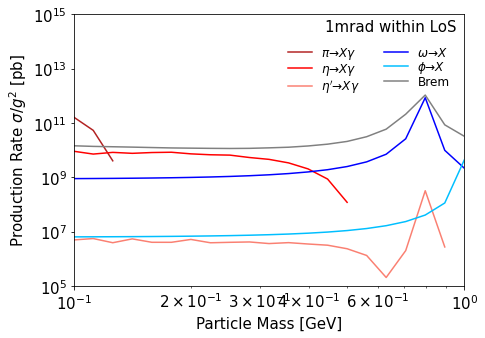

In [10]:
masses = masses = np.logspace(-1,0,41)
productions = [
    ["111"    , None       , "firebrick"   , r"$\pi \to X \gamma$"   ],   
    ["221"    , None       , "red"         , r"$\eta \to X \gamma$"  ],   
    ["331"    , None       , "salmon"      , r"$\eta' \to X \gamma$" ],  
    ["223"    , None       , "blue"        , r"$\omega \to X $"      ],   
    ["333"    , None       , "deepskyblue" , r"$\phi \to X $"        ],  
    ["Brem"   , None       , "gray"        , "Brem"                  ],   
]

ylims=[1e5,1e15]
xlims=[0.1,1]
plot=foresee.plot_production(
    masses = masses, 
    productions = productions,
    condition="logth<-3", 
    xlims=xlims,ylims=ylims, 
    xlabel=r"Particle Mass [GeV]", 
    ylabel=r"Production Rate $\sigma/g^2$ [pb]",
    legendloc=(0.99,0.925),
    fs_label=12,
    title=None,
    dolegend=True,
    ncol=2,
)
xtext=10**(np.log10(xlims[0]) + 0.98*(np.log10(xlims[1])-np.log10(xlims[0])))
ytext=10**(np.log10(ylims[0]) + 0.98*(np.log10(ylims[1])-np.log10(ylims[0])))
plot.text(xtext , ytext, r"1mrad within LoS" , color="k", va="top", ha="right", fontsize=15)
plot.show()

Let's first look at one benchmark scenario with $m_{A'}=100$ MeV and $g=10^{-5}$ using the function `foresee.get_llp_spectrum()`. By default, the result are saved in the `model/LLP_spectra` directory. However, here set `save_file=False` since we don't want to save the results but set `do_plot=True` to plot them. 

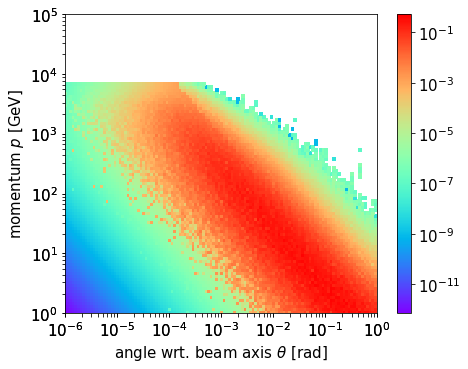

In [11]:
plot = foresee.get_llp_spectrum(0.1, coupling=1e-5, do_plot=True, save_file=False)
plot.show()

We can now produce a set of LLP spectra for various masses  (chosen to be equally spaced in log(mass)) and unit coupling and save them. 

In [12]:
masses = masses = np.logspace(-1,0,21)

for mass in masses:
    foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: ./model/LLP_spectra/14TeV_111_m_0.1.npy
save data to file: ./model/LLP_spectra/14TeV_221_m_0.1.npy
save data to file: ./model/LLP_spectra/14TeV_331_m_0.1.npy
save data to file: ./model/LLP_spectra/14TeV_223_m_0.1.npy
save data to file: ./model/LLP_spectra/14TeV_333_m_0.1.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_0.1.npy
save data to file: ./model/LLP_spectra/14TeV_111_m_0.11220184543019636.npy
save data to file: ./model/LLP_spectra/14TeV_221_m_0.11220184543019636.npy
save data to file: ./model/LLP_spectra/14TeV_331_m_0.11220184543019636.npy
save data to file: ./model/LLP_spectra/14TeV_223_m_0.11220184543019636.npy
save data to file: ./model/LLP_spectra/14TeV_333_m_0.11220184543019636.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_0.11220184543019636.npy
save data to file: ./model/LLP_spectra/14TeV_111_m_0.12589254117941673.npy
save data to file: ./model/LLP_spectra/14TeV_221_m_0.12589254117941673.npy
save data to file: ./model/LLP_spectra/14TeV

## 4. Count Eventrate in Detector

Before counting the number of decays within the detector volume, let us specify the detector geometry. For this we need

- the `distance` from the IP in meter (default: 480)
- the `length` in meter (default: 5)
- the `luminosity` in units of fb^-1 (default: 3000)
- the `selection` depending in `x.x` and `x.y` (default: `np.sqrt(x.x**2 + x.y**2)< 1`)
- the decay `channels` which the detector can see (default: None, meaning all of them)

The default correspond to the FASER2 detector.

In [13]:
distance, selection, length, luminosity, channels = 480, "np.sqrt(x.x**2 + x.y**2)< 1", 5, 3000, None
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

Let us look for one specific boson mass $m_{A'}=100$ MeV at how many particle decay inside the decay volume. This can be done using `get_events()` for which we need to specify again the mass and filename. Additionally, we can specify 

- the `couplings` for which we evaluate the event rate as numpy array (deault `np.logspace(-8,-3,51)`)
- the `preselectioncuts` when reading the LLP spectra in terms of momentum `p` and angle `th` (default: `th<0.01 and p>100`)
- the number `nsample` describing how many randomly choosen values of $\phi_{LLP}$ should sampled (default 1). This is only relevant for detectors that are not cylyndrical or not centered around the beam axis. 
- the production `modes` which should be considered
- the `energy` of the experiments

In [14]:
mass = 0.1 
output = foresee.get_events(mass=mass, energy=energy, couplings=np.logspace(-8,-3,6))
coups, ctaus, nsigs, momenta, weights = output
for coup,ctau,nsig in zip(coups, ctaus, nsigs):
    print ("epsilon =", '{:5.3e}'.format(coup), ": nsignal =", '{:5.3e}'.format(nsig))

epsilon = 1.000e-08 : nsignal = 2.088e-10
epsilon = 1.000e-07 : nsignal = 2.088e-06
epsilon = 1.000e-06 : nsignal = 2.088e-02
epsilon = 1.000e-05 : nsignal = 2.086e+02
epsilon = 1.000e-04 : nsignal = 1.902e+06
epsilon = 1.000e-03 : nsignal = 2.742e+09


The previous function also outputs the energy distribution of the bosons which decay inside the detector. Let's have a look at them.

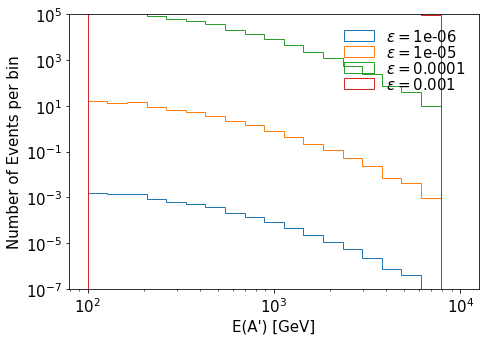

In [15]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
for coup,momentum,weight in zip(coups,momenta,weights):
    if sum(weight)<10**-5 : continue
    ax.hist([p.e for p in momentum], weights=weight, bins=np.logspace(2,4, 20), histtype='step', label=r"$\epsilon=$"+str(coup)) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10**-7,10**5) 
    ax.set_xlabel("E(A') [GeV]") 
    ax.set_ylabel("Number of Events per bin") 
    ax.legend(frameon=False, labelspacing=0)
plt.tight_layout()
plt.show()

FORESEE also includes a function `write_events()` which obtains an unweighted sample of LLP decay events and saves them as a HEPMC file. For this function, we need to specify
- the `mass` and `coupling` of the LLP
- the collision `energy`
- the number of events `numberevent` that should be samples (optional, default=10)
- the `filename` of the output file (optional, default=`model/events/<mass>_<coupling>.hepmc`)
- the z-position (in meter) of the beginning of the decay volume (optional, default=0)
- a random `seed` (optional, default=None)
- the `decaychannels` for which the event should bbe written to file (optional, default=None meaning that all channels are written to file)

At the moment, FORESEE only supports 2-body LLP decays. For all other cases, including those where no final state information was specified when initiating the `Model`, the LLP will not be decayed. 

In [16]:
foresee.write_events(filename="model/events/test.hepmc", mass=.1, coupling=1e-5, 
    energy="14", numberevent=3, zfront=0, notime=False, t0=0)

/Users/felixkling/Documents/GitHub/FORESEE/src/foresee.py:985: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  channels=np.array(channels).T


Let us have a look at a the output:

In [17]:
f = open("model/events/test.hepmc", 'r')
file_contents = f.read()
print (file_contents)

HepMC::Version 2.06.09
HepMC::IO_GenEvent-START_EVENT_LISTING
E 0 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 68.27987093774003 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 41.1570743248 212.6957155194 3061.1928526102 3061.1928526102 1 2 0
P 1 32 0.0020711986 0.0107037509 24.1556366646 24.1558461151 0.1 2 0 0 -1 0
P 2 11 0.0021825979 -0.0409619723 15.5657937046 15.5658477624 0.000511 1 0 0 0 0
P 3 -11 -0.0001113993 0.0516657232 8.58984296 8.5899983526 0.000511 1 0 0 0 0
E 1 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 68.27987093774003 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 114.4754436689 257.7337322789 2239.3361532117 2239.3361532117 1 2 0
P 1 32 0.047640933 0.107260344 199.7602900946 199.760349602 0.1 2 0 0 -1 0
P 2 11 0.0652523582 0.1091514832 190.5657970188 190.5658394508 0.0005109915 1 0 0 0 0
P 3 -11 -0.0176114252 -0.0018911393 9.1944929579 9.1945100333 0.0005109999 1 0 0 0 0
E 2 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 68.27987093774003 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 -656.9500757415 -289.4805725194 2805.090906

We can also use other fileformats, for example `.csv` files:  

In [18]:
foresee.write_events(filename="model/events/test.csv", mass=.1, coupling=1e-5, 
    energy="14", numberevent=3, zfront=0, notime=False, t0=0, filetype="csv")

## 5. Parameter Scan

In the following, we will get the LLP sensitivity reach for different detector configuraions. As an example, we show the FASER(2) reach for gauge boson. We just need to loop over different masses and use the previously introduced funtion `get_events`. The results will be written into a `.npy` file that we can store and plot later. **Currently, FORESEE only provides HEPMC output for LLP decays into two-body final states. Let's specify those decay _channels_**

- the nominal/default setup

In [19]:
#specify setup
luminosity, distance, length = 150, 480, 1.5
setup, selection, channels = "default", "np.sqrt(x.x**2 + x.y**2)<.1", ["pigamma","ee","mumu"]
foresee.set_detector(length=length, selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach  
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _  = foresee.get_events(nsample=1, mass=mass, energy=energy, couplings = np.logspace(-8,3,101))
    list_nevents.append(nevents)  
        
#save results
np.save("model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

/Users/felixkling/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## 6. Plot the Results

Now let's plot the results. We first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [20]:
setups = [
    ["14TeV_default.npy",    "FASER 150/fb"  , "firebrick", "solid", 0., 3         ],
    ["14TeV_default.npy",    "FASER 3/ab"    , "red",       "solid", 0., 3*150/3000],

]

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation)

In [21]:
bounds = [ 
    ["bounds_2201.01788.txt",    "2201.01788",   0.200, 2.5*10**-2, 0  ],
]

Finally, we can plot everything using `foresee.plot_reach()`. It returns a matplotlib instance, to which we can add further lines and which we can show or save. Below, we add the dark matter relict target line for a specific benchmark.

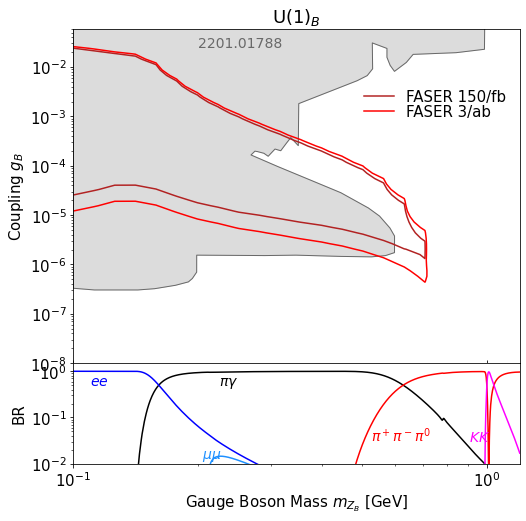

In [26]:
plot, ax, ax2 = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=[],
    title=r"U(1)$_{B}$", 
    xlims = [0.1,1.2], 
    ylims=[10**-8,0.06],
    xlabel=r"Gauge Boson Mass $m_{Z_{B}}$ [GeV]", 
    ylabel=r"Coupling $g_{B}$",
    legendloc=(1,0.86),
    branchings=branchings,
    figsize=(8,8),
)

plot.show()